# Heterodyne setup

This notebook focuses on metodologies presented in the work: 

[Time-dependent laser linewidth - beat-note digital acquisition and numerical analysis (2016)](https://opg.optica.org/oe/fulltext.cfm?uri=oe-24-24-27961&id=355513)

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import os
from optic.models.devices import photodiode, basicLaserModel
from optic.dsp.core import phaseNoise
from optic.models.amplification import OSA, get_spectrum
from optic.utils import parameters
from scipy.constants import c
from scipy.signal import hilbert
from IPython.display import display, Math

fontSmall = {'family':'serif', 'weight':'normal', 'size':12}
font = {'family':'serif', 'weight':'normal', 'size':16}
fontTitle = {'family':'serif', 'weight':'normal', 'size':20}

![Heterodyne Setup](IlustrationMedia/HeterodyneSetup.png)

500000


(-5.0, 5.0)

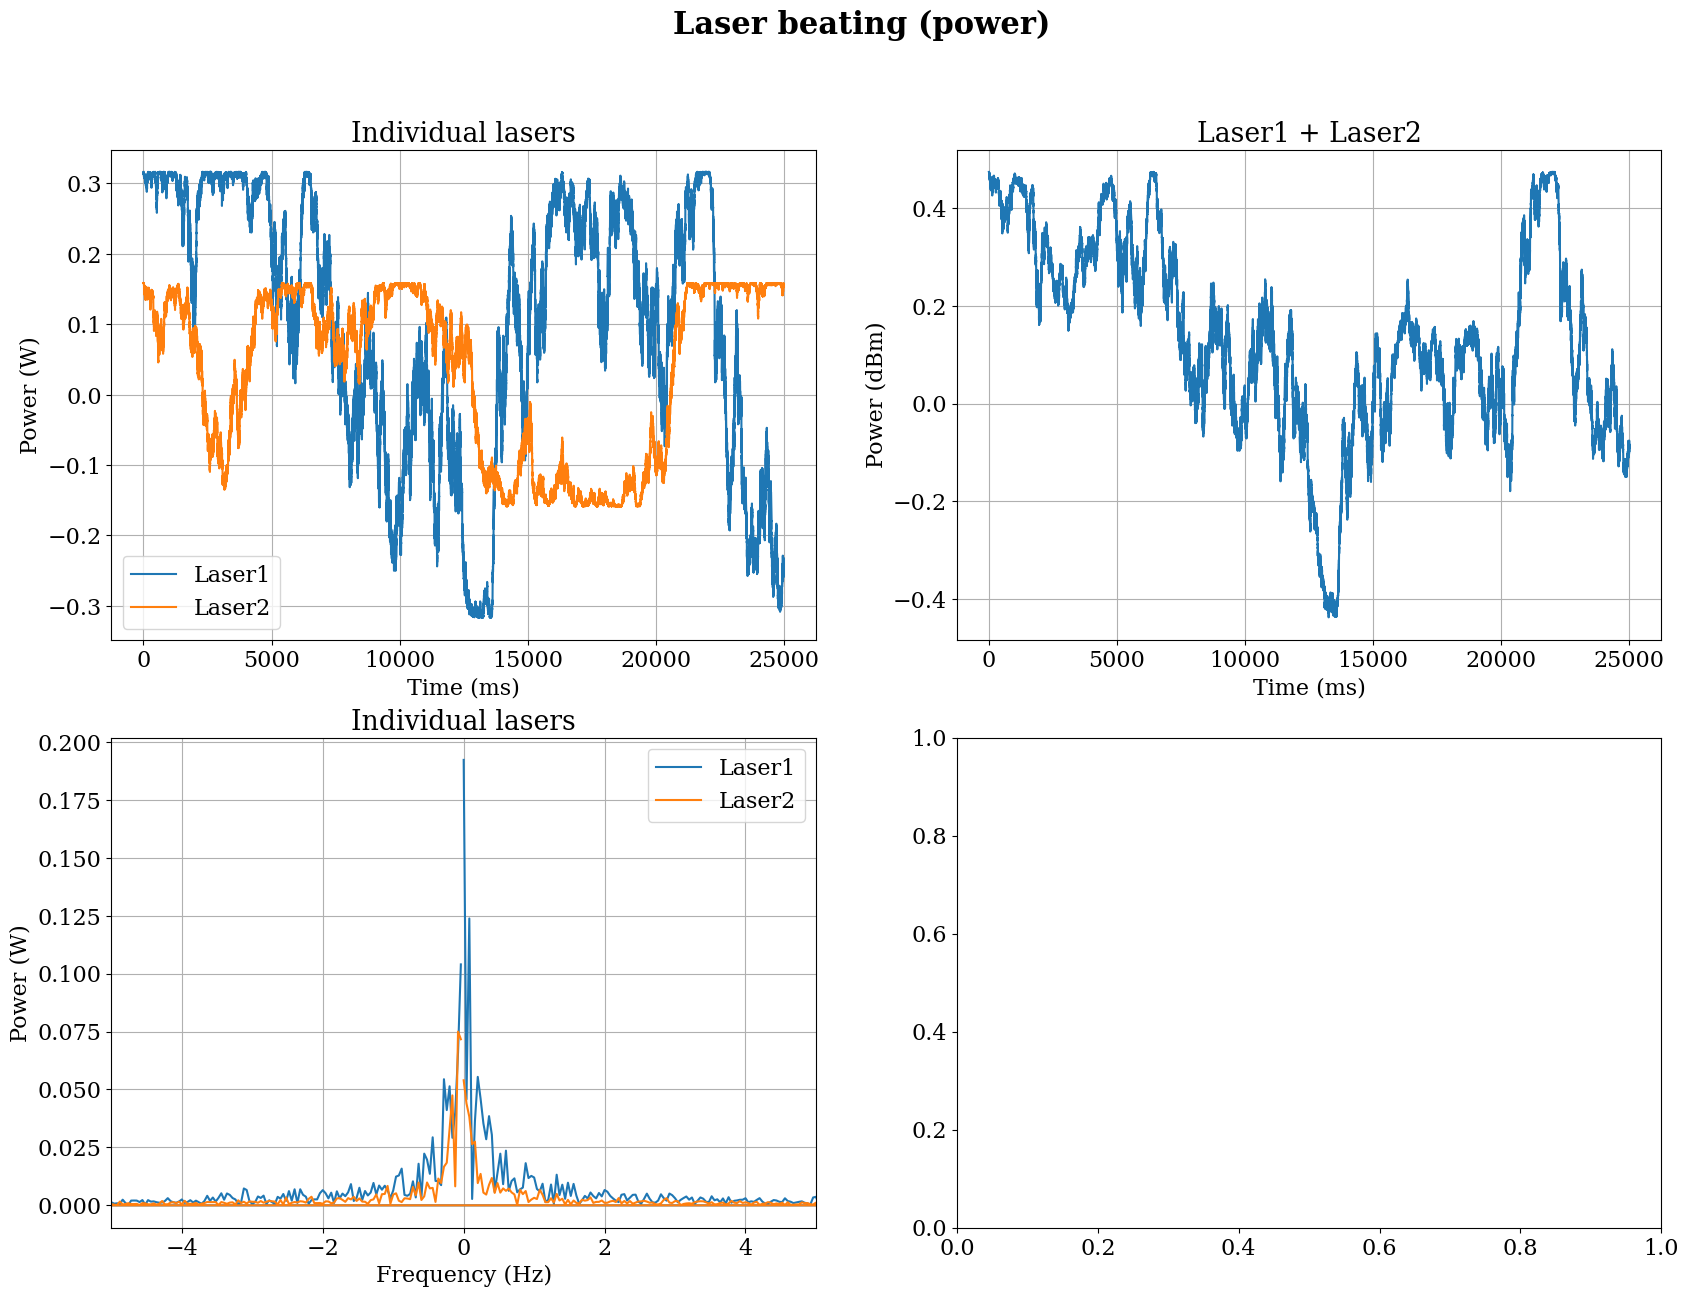

In [63]:
A1 = 1
A2 = 1

Fs = 20e3
Nsamples = 500000
tArray = np.linspace(0,Nsamples/Fs,Nsamples)

LaserParam1 = parameters()  # OptiCommPy default class for parameters (struct)
LaserParam1.P = 20  # Power in dBm
LaserParam1.lw = 0.1
LaserParam1.RIN_var = 1e-22
LaserParam1.Fs = Fs
LaserParam1.Ns = Nsamples

LaserParam2 = parameters()  # OptiCommPy default class for parameters (struct)
LaserParam2.P = 14 # Power in dBm
LaserParam2.lw = 0.1
LaserParam2.RIN_var = 1e-22
LaserParam2.Fs = Fs
LaserParam2.Ns = Nsamples


Laser1 = basicLaserModel(LaserParam1)
Laser2 = basicLaserModel(LaserParam2)

print(np.size(Laser1))

plt.rc('font',**font)
figure, ax = plt.subplots(2,2,figsize=(20,14))
figure.suptitle(f'Laser beating (power)',fontsize=22, weight='bold')

ax[0][0].plot(tArray*1e3,Laser1,label='Laser1')
ax[0][0].plot(tArray*1e3,Laser2,label='Laser2')
ax[0][0].set_xlabel('Time (ms)')
ax[0][0].set_ylabel('Power (W)')
ax[0][0].set_title('Individual lasers')
ax[0][0].grid()
ax[0][0].legend()

ax[0][1].plot(tArray*1e3,Laser1+Laser2)
ax[0][1].set_xlabel('Time (ms)')
ax[0][1].set_ylabel('Power (dBm)')
ax[0][1].set_title('Laser1 + Laser2')
ax[0][1].grid()

[Hl1,wl1] = [np.fft.fft(Laser1),np.fft.fftfreq(len(Laser1), d=1/Fs)]
[Hl2,wl2] = [np.fft.fft(Laser2),np.fft.fftfreq(len(Laser2), d=1/Fs)]

ax[1][0].plot(wl1,np.abs(Hl1)/Nsamples,label='Laser1')
ax[1][0].plot(wl2,np.abs(Hl2)/Nsamples,label='Laser2')
ax[1][0].set_xlabel('Frequency (Hz)')
ax[1][0].set_ylabel('Power (W)')
ax[1][0].set_title('Individual lasers')
ax[1][0].grid()
ax[1][0].legend()
ax[1][0].set_xlim(-5,5)


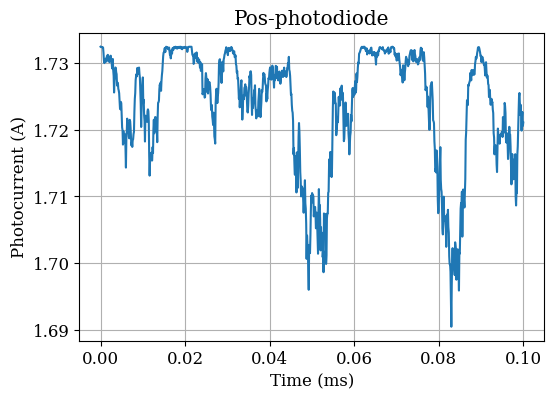

In [117]:
plt.rc('font',**fontSmall)
plt.figure(figsize=(6,4))
plt.plot(tArray,photodiode(Laser1+Laser2))
plt.xlabel('Time (ms)')
plt.ylabel('Photocurrent (A)')
plt.title('Pos-photodiode')
plt.grid()

# Heterodyne setup (alternative code)

In [51]:
# Transmitter parameters:
paramTx = parameters()
paramTx.NSb = 2**10          # number os symbols
paramTx.SpS = 256*256           # samples per symbol
paramTx.Rs  = 100e9           # symbol rate
paramTx.lw  = 1e8           # laser linewidth
paramTx.Nch = 2              # number of channels
paramTx.Nmodes   = 1         # number of modes
paramTx.Pch_dBm  = -10       # channel power
paramTx.freqSpac = 2e9       # channel bandwith
# paramTx.Fc       = c/1540e-9 # central frequency

freqMod = 100e12  # Carrier frequency (Hz)
timeMultiplier = 5 # Time signal multiplier

# CW signal with two optical channels: 1530 and 1550 nm.
t = np.arange(0, paramTx.NSb * paramTx.SpS)
Fs = paramTx.Rs*paramTx.SpS

# central frequencies of the WDM channels
freqGrid = (
    np.arange(-np.floor(paramTx.Nch / 2), np.floor(paramTx.Nch / 2) + 1, 1)
    * paramTx.freqSpac
)
if (paramTx.Nch % 2) == 0:
    freqGrid += paramTx.freqSpac / 2
# linear power
power_lin = 10**((paramTx.Pch_dBm)/10 - 3)
# comb generation
sigTxWDM = np.zeros((len(t), paramTx.Nmodes), dtype="complex")
for indCh in range(paramTx.Nch):
    for indMode in range(paramTx.Nmodes):
        pho_pn_lo = phaseNoise(paramTx.lw, len(t), 1/Fs)
        sigLO   = np.sqrt(power_lin)*np.exp(1j*pho_pn_lo)
        sigTxWDM[:, indMode] += sigLO * np.exp(1j * 2 * np.pi * (freqGrid[indCh] / Fs) * t)

modulatedSig = sigTxWDM[:,0]*np.exp(1j * 2 * np.pi * (freqMod/Fs) * t)

MainFreq = freqMod - paramTx.freqSpac/2
LOFreq = freqMod + paramTx.freqSpac/2
text1='Used~for~plotting~lasers~OSA,~operating~in~THz~frequencies'
display(Math(f'Main~carrier~frequency = {MainFreq*1e-12}~THz ~({np.round(1e9*c/MainFreq,2)}nm)~~|~~LO~carrier~frequency = {LOFreq*1e-12}~THz ~({np.round(1e9*c/LOFreq,2)}nm)'))
display(Math(f'Frequency~spacing = {paramTx.freqSpac*1e-9}~GHz ~~|~~ Central~frequency = {freqMod*1e-12}~THz'))
display(Math(f'Sampling~frequency = {np.round(Fs*1e-12,2)}~THz~({text1})'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

/tmp/ipykernel_370182/1423623099.py:55: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(datapath+"/"+"Beatnote_signal(OSA)" + ".png", transparent=False, facecolor="white", bbox_inches="tight")


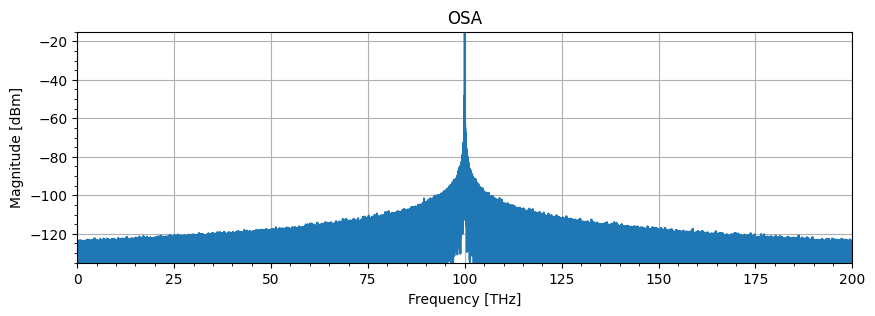

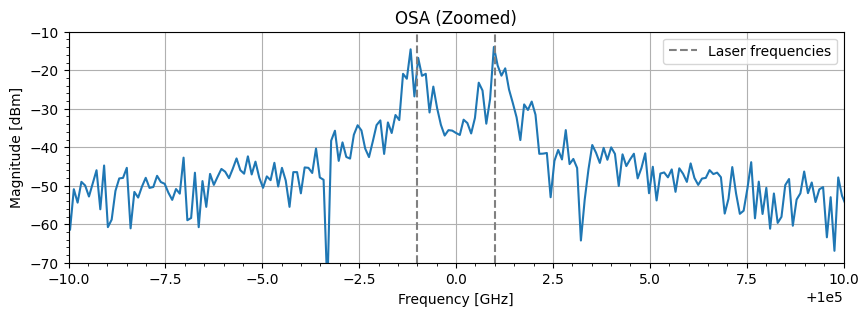

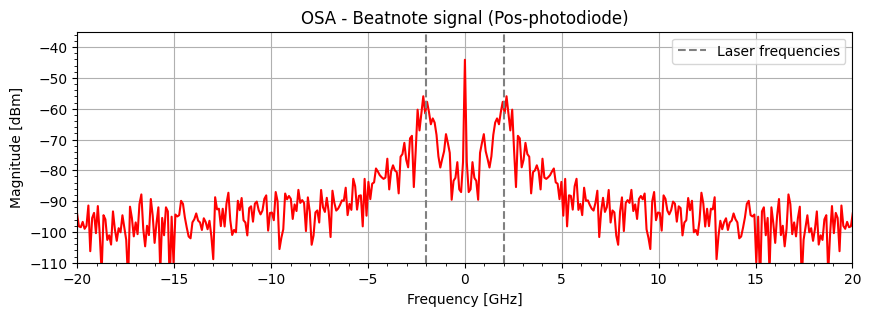

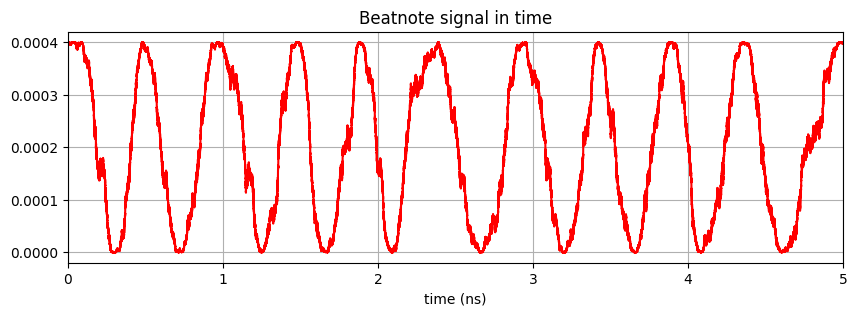

In [59]:
plt.rcParams["figure.figsize"] = (10,3) 

freqs, ZX = get_spectrum(modulatedSig, Fs, 0)

yMin = -70
yMax = ZX.max() + 10
_,ax = plt.subplots(1)
ax.plot( 1e-12*(c/freqs), ZX, label="X Pol.")
ax.set_ylim([yMin, yMax])   
ax.set_xlabel("Frequency [THz]")
ax.set_ylabel("Magnitude [dBm]")
ax.minorticks_on()
ax.grid(True)
ax.set_xlim([0,200])
ax.set_ylim([-135,-15])
ax.set_title('OSA')

yMin = -70
yMax = ZX.max() + 10
_,ax = plt.subplots(1)
ax.plot( 1e-9*(c/freqs), ZX)
ax.set_ylim([yMin, yMax])   
ax.set_xlabel("Frequency [GHz]")
ax.set_ylabel("Magnitude [dBm]")
ax.minorticks_on()
ax.grid(True)
ax.set_xlim([99.99*1e3,100.01*1e3])
ax.set_ylim([-70,-10])
ax.vlines(x=MainFreq*1e-9,ymin=-70,ymax=-10,linestyles='dashed',color='gray')
ax.vlines(x=LOFreq*1e-9,ymin=-70,ymax=-10,linestyles='dashed',color='gray',label='Laser frequencies')
ax.legend()
ax.set_title('OSA (Zoomed)')

sigTxPosPhoto = photodiode(modulatedSig)

freqs, ZX = get_spectrum(sigTxPosPhoto, Fs, 0)
yMin = -70
yMax = ZX.max() + 10
_,ax = plt.subplots(1)
ax.plot( 1e-9*(c/freqs), ZX, color='red')
ax.set_title('OSA - Beatnote signal (Pos-photodiode)')
ax.set_ylim([yMin, yMax])   
ax.set_xlabel("Frequency [GHz]")
ax.set_ylabel("Magnitude [dBm]")
ax.minorticks_on()
ax.grid(True)
ax.set_xlim([-20,20])
ax.set_ylim([-110,-35])
ax.vlines(x=(MainFreq-LOFreq)*1e-9,ymin=-110,ymax=-35,linestyles='dashed',color='gray')
ax.vlines(x=(-MainFreq+LOFreq)*1e-9,ymin=-110,ymax=-35,linestyles='dashed',color='gray',label='Laser frequencies')
ax.legend()

datapath = 'Media/HeterodyneDetection'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"Beatnote_signal(OSA)" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

plt.figure(figsize=(10,3))
plt.plot(1e9*t/Fs,sigTxPosPhoto, color='red')
plt.xlabel('time (ns)')
plt.xlim(0,5)
plt.grid()
plt.title('Beatnote signal in time')

datapath = 'Media/HeterodyneDetection'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"Beatnote_signal" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

plt.rcParams["figure.figsize"] = (8,6) 

# Beatnote signal treatment

![Relevant Transformations](IlustrationMedia/RelevantTransformations.png)

## Frequency noise

Path: A $\rightarrow$ D $\rightarrow$ C $\rightarrow$ E

/home/caio/Documentos/PythonVenvs/TCCVenv/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/caio/Documentos/PythonVenvs/TCCVenv/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Beatnote signal in time')

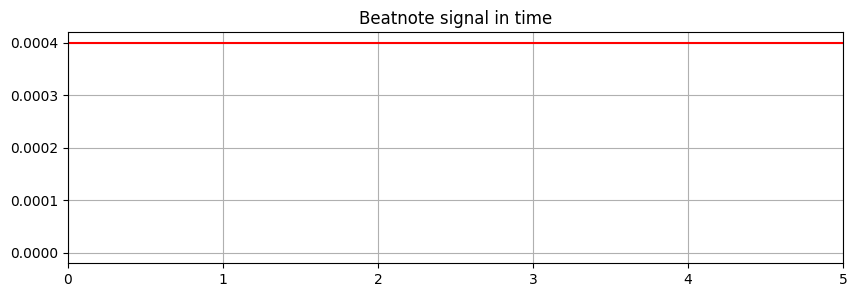

In [61]:
plt.figure(figsize=(10,3))
plt.plot(hilbert(sigTxPosPhoto), color='red')
plt.xlim(0,5)
plt.grid()
plt.title('Beatnote signal in time')

Text(0.5, 1.0, 'Beatnote signal (Hilbert)')

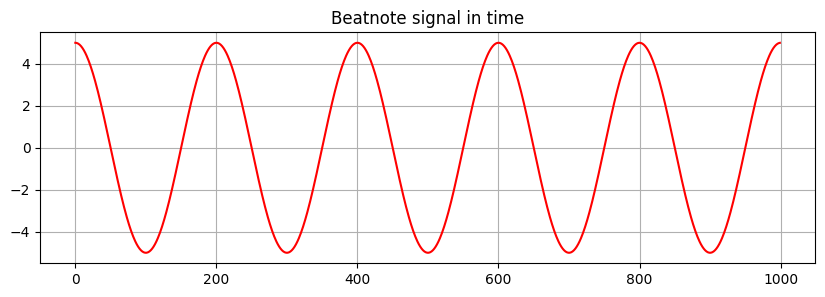

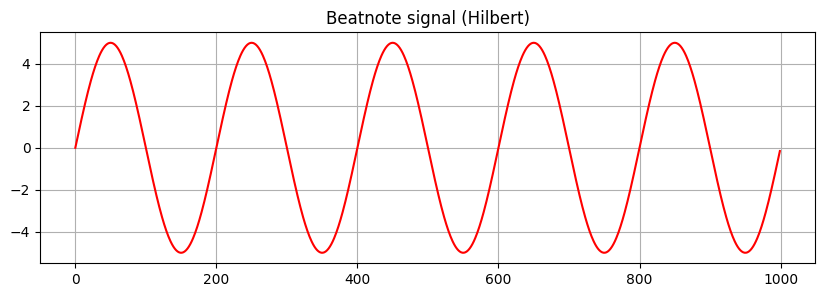

In [70]:
ta = np.arange(0,1000)
sig = 5*np.cos(2*np.pi*ta/200)

plt.figure(figsize=(10,3))
plt.plot(sig, color='red')
plt.grid()
plt.title('Beatnote signal in time')

plt.figure(figsize=(10,3))
plt.plot(np.imag(hilbert(sig)), color='red')
plt.grid()
plt.title('Beatnote signal (Hilbert)')

## Time-Dependent Linewidth

Path: A $\rightarrow$ B